In [24]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn
import statsmodels.tsa.stattools as ts
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 

In [2]:
# get history market data
hist = yf.Ticker("MSFT").history(period="max")

<AxesSubplot:xlabel='Date'>

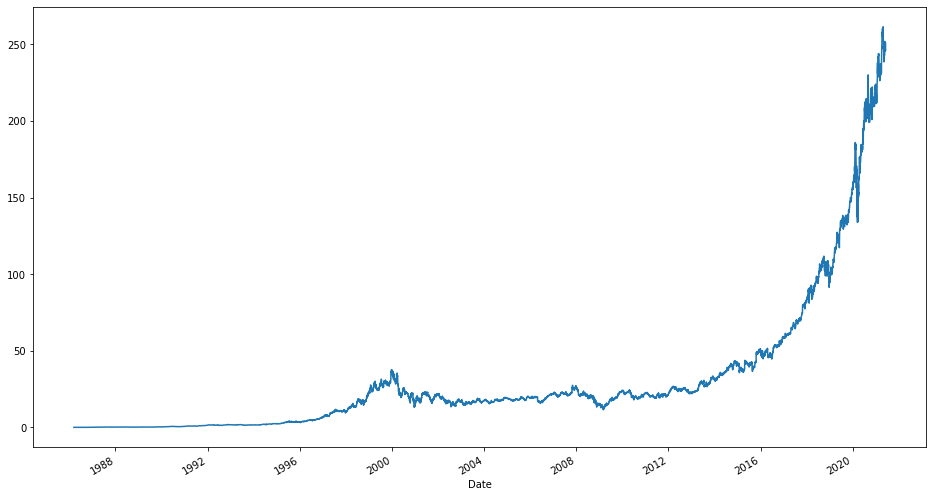

In [3]:
hist['Close'].plot(figsize=(16,9))

In [4]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.056108,0.064359,0.056108,0.061608,1031788800,0.0,0.0
1986-03-14,0.061608,0.064909,0.061608,0.063809,308160000,0.0,0.0
1986-03-17,0.063809,0.065459,0.063809,0.064909,133171200,0.0,0.0
1986-03-18,0.064909,0.065459,0.062708,0.063258,67766400,0.0,0.0
1986-03-19,0.063258,0.063809,0.061608,0.062158,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2021-05-28,251.000000,252.080002,249.559998,249.679993,18270200,0.0,0.0
2021-06-01,251.229996,251.289993,246.960007,247.399994,23213300,0.0,0.0
2021-06-02,248.130005,249.270004,245.839996,247.300003,19406700,0.0,0.0


In [5]:
hist['Date'] = hist.index

# set id as index
id_list = list(range(hist.shape[0]))
hist.index = id_list

In [6]:
from fastai.tabular.all import *

# create date features
add_datepart(hist, 'Date')
hist.drop('Elapsed', axis=1, inplace=True)

In [7]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
0,0.056108,0.064359,0.056108,0.061608,1031788800,0.0,0.0,1986,3,11,13,3,72,False,False,False,False,False,False
1,0.061608,0.064909,0.061608,0.063809,308160000,0.0,0.0,1986,3,11,14,4,73,False,False,False,False,False,False
2,0.063809,0.065459,0.063809,0.064909,133171200,0.0,0.0,1986,3,12,17,0,76,False,False,False,False,False,False
3,0.064909,0.065459,0.062708,0.063258,67766400,0.0,0.0,1986,3,12,18,1,77,False,False,False,False,False,False
4,0.063258,0.063809,0.061608,0.062158,47894400,0.0,0.0,1986,3,12,19,2,78,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8875,251.000000,252.080002,249.559998,249.679993,18270200,0.0,0.0,2021,5,21,28,4,148,False,False,False,False,False,False
8876,251.229996,251.289993,246.960007,247.399994,23213300,0.0,0.0,2021,6,22,1,1,152,False,True,False,False,False,False
8877,248.130005,249.270004,245.839996,247.300003,19406700,0.0,0.0,2021,6,22,2,2,153,False,False,False,False,False,False
8878,245.220001,246.339996,243.000000,245.710007,25307700,0.0,0.0,2021,6,22,3,3,154,False,False,False,False,False,False


In [28]:
# create date features
msft = hist[['Open','High','Low','Volume','Dividends','Stock Splits','Month','Week','Day','Dayofweek']]

In [29]:
msft

,Open,High,Low,Volume,Dividends,Stock Splits,Month,Week,Day,Dayofweek
0,0.056108,0.064359,0.056108,1031788800,0.0,0.0,3,11,13,3
1,0.061608,0.064909,0.061608,308160000,0.0,0.0,3,11,14,4
2,0.063809,0.065459,0.063809,133171200,0.0,0.0,3,12,17,0
3,0.064909,0.065459,0.062708,67766400,0.0,0.0,3,12,18,1
4,0.063258,0.063809,0.061608,47894400,0.0,0.0,3,12,19,2
...,...,...,...,...,...,...,...,...,...,...
8875,251.000000,252.080002,249.559998,18270200,0.0,0.0,5,21,28,4
8876,251.229996,251.289993,246.960007,23213300,0.0,0.0,6,22,1,1
8877,248.130005,249.270004,245.839996,19406700,0.0,0.0,6,22,2,2
8878,245.220001,246.339996,243.000000,25307700,0.0,0.0,6,22,3,3


In [30]:
y = hist['Close']
X_train = msft[:int(msft.shape[0]*6/7)].values
X_test = msft[int(msft.shape[0]*6/7):].values
y_train = y[:int(msft.shape[0]*6/7)].values
y_test = y[int(msft.shape[0]*6/7):].values

In [31]:
# check mean-reverting condition
arr = y.values
ro = ts.adfuller(arr, regression='ct', maxlag=1, autolag='AIC') 
print ('test statistic =',ro[0])  
print ('critical value =',ro[4])

test statistic = 4.1586941253370915
critical value = {'1%': -3.9597900837772704, '5%': -3.4109846405015176, '10%': -3.127341286594731}


In [46]:
tscv = TimeSeriesSplit(n_splits=30)
i = 1
mse_score = []
for tr_indx, val_indx in tscv.split(X_train):
    X_tr, X_val = X_train[tr_indx], X_train[val_indx]
    y_tr, y_val = y_train[tr_indx], y_train[val_indx]
    
    model = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
    model.fit(X_tr, y_tr)
    y_hat = model.predict(X_val)
    score = mean_squared_error(y_val, y_hat)
    mse_score.append(score)

In [47]:
print("The average of mean squared score", np.mean(mse_score))

The average of mean squared score 0.019856636203776038


In [56]:
lr = linear_model.LinearRegression(fit_intercept=True, n_jobs=1, normalize=True)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mean_squared_error(y_test, y_pred)

0.8218412286664228